In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('ab_browser_test.csv', header=0, sep=',')
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [3]:
data.shape

(566134, 6)

In [4]:
(data[data.slot == 'exp']['n_clicks'].sum() - data[data.slot == 'control']['n_clicks'].sum()) / data[data.slot == 'control']['n_clicks'].sum() * 100

1.6135689824415809

In [5]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [6]:
exp_samples = get_bootstrap_samples(np.array(data[data.slot == 'exp']['n_clicks']), 100)
cont_samples = get_bootstrap_samples(np.array(data[data.slot == 'control']['n_clicks']), 100)

exp_mean = list(map(np.mean, exp_samples))
cont_mean = list(map(np.mean, cont_samples))
exp_median = list(map(np.median, exp_samples))
cont_median = list(map(np.median, cont_samples))
print("Exp mean: {}; Control mean: {} \n Exp median: {}; Control median: {}".format(stat_intervals(exp_mean), 
                                                                                    stat_intervals(cont_mean), 
                                                                                    stat_intervals(exp_median), 
                                                                                    stat_intervals(cont_median)))

Exp mean: [11.51798254 11.65325902]; Control mean: [11.21423684 11.35477229] 
 Exp median: [5. 5.]; Control median: [4. 4.]


In [16]:
from matplotlib import pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


(array([5.59077e+05, 6.09600e+03, 7.34000e+02, 1.56000e+02, 3.90000e+01,
        1.40000e+01, 1.10000e+01, 2.00000e+00, 4.00000e+00, 1.00000e+00]),
 array([  0. ,  86.3, 172.6, 258.9, 345.2, 431.5, 517.8, 604.1, 690.4,
        776.7, 863. ]),
 <a list of 10 Patch objects>)

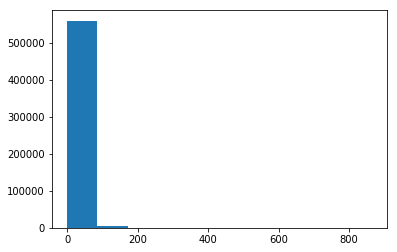

In [18]:
plt.hist(data.n_clicks)

In [22]:
np.random.seed(0)
n_boot_samples = 500

control_samples = get_bootstrap_samples(np.array(data[data.slot == 'control']['n_clicks']), n_boot_samples)

In [25]:
def variance(lst):
    return ((lst - lst.mean()) ** 2).sum()

In [26]:
control_boot_chi_squared = list(map(variance, control_samples))
control_boot_norm = list(map(np.mean, control_samples))

In [31]:
from scipy import stats

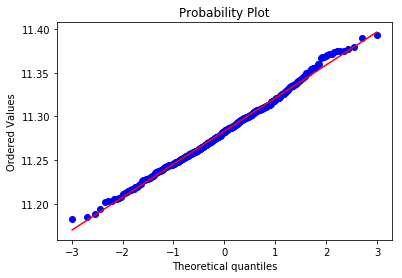

In [34]:
a = stats.probplot(control_boot_norm, dist="norm", plot=pylab)
pylab.show()

In [37]:
a[1][2] ** 2

0.9959537742082024

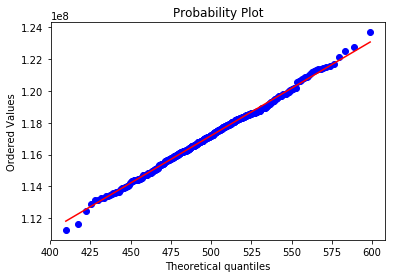

In [39]:
a = stats.probplot(control_boot_chi_squared, dist="chi2", 
                     sparams=(n_boot_samples-1), plot=pylab)
pylab.show()

In [41]:
a[1][2] ** 2

0.9972851848247721

In [46]:
data_exp = data[data.slot == 'exp'][['userID', 'n_clicks']]
data_control = data[data.slot == 'control'][['userID', 'n_clicks']]

In [49]:
data_exp = data_exp.groupby('userID').sum()

In [50]:
data_control = data_control.groupby('userID').sum()

In [51]:
stats.mannwhitneyu(data_exp, data_control)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

In [52]:
data_exp.mean()

n_clicks    11.589352
dtype: float64

In [53]:
data_control.mean()

n_clicks    11.287332
dtype: float64

In [59]:
set(data.browser.values)

{'Browser #14',
 'Browser #17',
 'Browser #2',
 'Browser #20',
 'Browser #22',
 'Browser #4'}

In [63]:
ps = []

for brow in set(data.browser.values):
    ans = stats.mannwhitneyu(data[(data.browser == brow) & (data.slot == 'exp')]['n_clicks'],
                                 data[(data.browser == brow) & (data.slot == 'control')]['n_clicks'])
    print(brow, ans)
    ps.append(ans[1])
    
ps    

Browser #14 MannwhitneyuResult(statistic=806984730.5, pvalue=0.0)
Browser #2 MannwhitneyuResult(statistic=1522572720.0, pvalue=0.0272438604197241)
Browser #17 MannwhitneyuResult(statistic=131389681.0, pvalue=0.03740060143010802)
Browser #20 MannwhitneyuResult(statistic=143791805.0, pvalue=0.45366656388735377)
Browser #4 MannwhitneyuResult(statistic=3072447765.0, pvalue=0.40760617658454984)
Browser #22 MannwhitneyuResult(statistic=2547597959.5, pvalue=0.2574055152210032)


[0.0,
 0.0272438604197241,
 0.03740060143010802,
 0.45366656388735377,
 0.40760617658454984,
 0.2574055152210032]

In [70]:
from statsmodels.stats.multitest import multipletests

reject, new_ps, _, __ = multipletests(ps, alpha=0.05, method='holm')

In [71]:
reject

array([ True, False, False, False, False, False])

In [72]:
new_ps

array([0.        , 0.1362193 , 0.14960241, 0.81521235, 0.81521235,
       0.77221655])

In [73]:
for brow in set(data.browser.values):
    for group in ['exp', 'control']:
        data_slice = data[(data.browser == brow) & (data.slot == group)]
        percentage = data_slice['n_nonclk_queries'].sum() / data_slice['n_queries'].sum() * 100
        print("{}, {}: {}".format(group, brow, percentage))

exp, Browser #14: 43.755617361273295
control, Browser #14: 57.59041136008114
exp, Browser #2: 44.982746948554706
control, Browser #2: 45.96274717919465
exp, Browser #17: 36.93741284866483
control, Browser #17: 36.29936674628208
exp, Browser #20: 38.97737648371716
control, Browser #20: 40.540484743383296
exp, Browser #4: 45.14294190358467
control, Browser #4: 46.97092963514274
exp, Browser #22: 39.85394721969546
control, Browser #22: 40.593976593513354
